<h1>Problem Set 3</h1> 
<h3><center>Quantitative Macro</center></h3>

<center>Pau Belda-i-Tortosa</center>,

<center>October 2018</center>

<h3>Question 1: Computing transitions in a RA economy.</h3>

Consider the typical Neoclassical Growth Model (NGM), with a Cobb-Douglas production function that includes a productivity parameter z. 

*a) Compute the steady-state. Choose z to match an annual capital-output ratio of 4, and an
investment-output ratio of .25.*

We have a system of five equations (the steady state Euler Equation, the production function, the budget constraint, the capital-output ratio, the investment-output ratio) and FIVE unknowns (capital, output, consumption, beta, delta). Solving this system of nonlinear equations we get the steady state values:

(1) $EE_{ss}: 1 = \beta(1+F_k - \delta)$

(2) Production function: $y = k^{1-\theta}(zh)^\theta$

(3) Budget constraint: $c^* = y^* - \delta k^*$

(4) Capital-output ratio: $k^*/y^*=4$

(5) Investment-ouptut ratio: $\frac{\delta^* k^*}{Y^*} = 0.25$
where

$F_k = (1-\delta)(\frac{zh}{k})^\theta$

and the initial values are:
$h = 0.31$; $\theta=0.67$.   

In [3]:
from numpy import *
from scipy.optimize import *

def Ramsey(x):
    h=0.31
    theta=0.67
    z=1.63
    k = x[0]
    y = x[1]
    c = x[2]
    beta = x[3]
    delta = x[4]

    F = empty((5))
    F[0]= 1 - beta*(1 - delta + (1-theta)*pow(z*h, theta)*pow(k, -theta))               
    F[1]= y - pow(k, 1-theta)*pow(z*h, theta)
    F[2]= c - y + delta*k
    F[3]= k/y - 4
    F[4]=(delta*k)/y - 0.25
    return F

xGuess= array([4,1,1,1,0.06])
x = fsolve(Ramsey, xGuess)
print ("SS capital=", "{0:.2f}".format(x[0]))
print ("SS output=", "{0:.2f}".format(x[1]))
print ("SS consumption=", "{0:.2f}".format(x[2]))
print ("beta=", "{0:.2f}".format(x[3]))
print ("delta", "{0:.4f}".format(x[4]))  

SS capital= 4.00
SS output= 1.00
SS consumption= 0.75
beta= 0.98
delta 0.0625


Now we have the parameters values that makes the system of equations reach a nice solution. What is next? We are gonna program the Ramsey model as a Python class and solve the next exercises inside this environment. 

In [4]:
import numpy as np
import mpmath as mp
import sympy
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize

class ramseyModel(object):
    
    def __init__(self, params, k=None, c=None):
        """
        Represents the Ramsey model 
        
        Definition of exogenous parameters of the Ramsey Model
            1) theta: labor share.  
            2) beta: discount factor
            3) z: initial level of technology
            4) delta: rate of capital depreciation
            5) h: hours of labor


        Attributes: 
            1) params: a dictionary of parameters and their values
            2) k: an initial condition for the state variable k 
            3) c: an initial condition for the control variable c
        
        """
        # current value of state variable, k
        self.k            = k
        # current value of the control variable, c
        self.c            = c
        # dictionary of parameter values
        self.param_dict   = params
        # dictionary of steady state values        
        self.SS_dict      = {'k_ss':self.set_k_ss(self.param_dict), 
                             'c_ss':self.set_c_ss(self.param_dict),
                             's_ss':self.set_s_ss(self.param_dict)}

         
    def set_k_ss(self, params): 
        """
        The steady-state level of capital stock is a function of the exogenous parameters.
        """
        # extract params
        delta = params['delta']
        beta   = params['beta']
        theta = params['theta']
        h = params ['h']
        z = params ['z']
        v = params ['v']
        
    
        return pow(((1-theta)/((1/beta)+delta+v-1)), (1/theta))*(z*h)
    
    def set_c_ss(self, params): 
        """
        The steady-state level of consumption per effective worker is a direct 
        function of the exogenous parameters and the steady-state level of capital
        stock. 
        """
        # extract params
        theta = params['theta']
        h = params ['h']
        delta  = params['delta']
        z = params ['z']
        k_ss = self.set_k_ss(params)
        
        return pow(k_ss, 1-theta)*pow(z*h, theta) - delta*k_ss

    def set_s_ss(self, params):
        """ 
        Steady state savings rate of the Ramsey economy
        """
        # extract params
        delta = params['delta']
        return delta

    def capital(self, k, c):
        """
        Law of motion of capital.
        Inputs: k_t, c_t
        Returns: k_t+1
        """
        # extract params
        theta = self.param_dict['theta']
        delta = self.param_dict['delta']
        h = self.param_dict['h']
        z = self.param_dict['z']
        v = self.param_dict['v']
    
        return pow(k, 1-theta)*pow(z*h, theta) - c + (1-delta-v)*k
 
    def ee(self, k, c):
        """
        Euler equation, which shows the inter-temporal trade-off between today's and tomorrow's 
        consumption.
        Inputs: k_t, c_t
        Returns: c_t+1      
        """
        # extract params
        h = self.param_dict['h']
        z = self.param_dict['z']
        delta = self.param_dict['delta']
        theta = self.param_dict['theta']
        beta = self.param_dict['beta']
        v = self.param_dict['v']
    
        return c*beta*(1 - delta - v + (1-theta)*pow(z*h, theta)*pow(k, -theta))

    def nextperiod(self):
        """
        Update the state and control variables.           
        """
        self.k = self.capital(self.k, self.c) 
        self.c = self.ee(self.k, self.c)

    def sample_path(self, n=None):
        """
        Generate sample path of length n starting from the current state
        """
        path = np.zeros(shape=(n, 2))
        
        for t in range(n):
            path[t, 0] = self.k
            path[t, 1] = self.c
            self.nextperiod()
        
        return path

    def ss(self, k0=None, c0=None):
        """     
        Finds the steady state for the Ramsey economy using a root solver and an initial guess.        
        """
        
        def ramseySS(x): 
            out = [self.capital(x[0], x[1]) - x[0]] # k_t+1=k_t
            out.append(self.ee(x[0], x[1]) - x[1]) # c_t+1=c_t
            return out
        x=optimize.fsolve(func=ramseySS, x0=(k0, c0))
        return x

    def forward_shoot(self, k0=None, c0=None, tol=1.5e-08):
        """       
        Computes the full, non-linear saddle path for the Ramsey model using the 
        'forward shooting' algorithm (Judd (1992)).         
        """
        # extract params
        theta = self.param_dict['theta']
        h = self.param_dict['h']
        z = self.param_dict['z']
        
        # compute steady state values
        k_ss, c_ss = self.SS_dict['k_ss'], self.SS_dict['c_ss']
        
        if k0 <= k_ss:
            c_l = 0
            c_h = c_ss
        else:
            c_l = c_ss
            c_h = pow(k0, 1-theta)*pow(z*h, theta) 
        c0 = (c_h + c_l) / 2
        self.k, self.c = k0, c0
        
        # Initialize a counter
        count  = 0
        n_iter = 0

        # Forward Shooting Algorithm
        while 1:
            self.nextperiod()
            dist = np.abs(((self.k - k_ss)**2 + (self.c - c_ss)**2)**0.5)
            count = count + 1
            if k0 <= k_ss:
                if self.k > k_ss:
                    if dist < tol:
                        break
                    else: # initial c_l too low!
                        c_l = c0
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
                if self.c > c_ss:
                    if dist < tol:
                        break
                    else: # initial c_h too high!
                        c_h = c0 
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
            else:
                if self.k < k_ss:
                    if dist < tol:
                        break
                    else: # initial c_l too high!
                        c_h = c0 
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
                if self.c < c_ss:
                    if dist < tol:
                        break
                    else: # initial c_l too low!
                        c_l = c0
                        c0 = (c_h + c_l) / 2
                        self.k, self.c = k0, c0
                        count = 0
                
        self.k, self.c = k0, c0
        solutionPath = self.sample_path(count)


        return [self.c, solutionPath, count, dist]    

To check that this class is working well, let's solve again the first steady state. 

In [5]:
# Steady state of section 1a)

# create a dictionary objects storing the parameter values
params = {'theta':0.67, 'delta':0.0625, 'h':0.31, 'beta':0.9804, 'z':1.63, 'v':0}
# Create an instance of the class ramseyDS
ramsey = ramseyModel(params)


solution=ramsey.ss(k0=3, c0=0.8)
k_ss=solution[0]
c_ss=solution[1]
y_ss=0.0625*k_ss+c_ss
v=k_ss/y_ss
t=0.0625*k_ss/y_ss
print ("SS capital=", "{0:.2f}".format(solution[0]))
print ("SS consumption=", "{0:.2f}".format(solution[1]))
print ("SS output=", "{0:.2f}".format(y_ss))
print ("capital/output=", "{0:.2f}".format(v))
print ("investment/output", "{0:.2f}".format(t))

SS capital= 4.00
SS consumption= 0.75
SS output= 1.00
capital/output= 4.00
investment/output 0.25


Indeed, we get the same solutions as before. Now let's do section b):

**Double permanently the productiviy parameter z and solve for the new steady state.**

In [6]:
# Steady state of section 1b) Shock over productivity. 
params = {'theta':0.67, 'delta':0.0625, 'h':0.31, 'beta':0.9804, 'z':3.26, 'v':0}
ramsey = ramseyModel(params)
solution=ramsey.ss(k0=4, c0=1)
k_ss=solution[0]
c_ss=solution[1]
y_ss=0.0625*k_ss+c_ss
v=k_ss/y_ss
t=0.0625*k_ss/y_ss
print ("SS capital=", "{0:.2f}".format(solution[0]))
print ("SS consumption=", "{0:.2f}".format(solution[1]))
print ("SS output=", "{0:.2f}".format(y_ss))
print ("capital/output=", "{0:.2f}".format(v))
print ("investment/output", "{0:.2f}".format(t))

SS capital= 8.00
SS consumption= 1.50
SS output= 2.00
capital/output= 4.00
investment/output 0.25


Doubling the productivity we double capital, consumption and output. 

**c) Compute the transition from the first to the second steady state and report the time-path for savings, consumption, labor and output.**

In [ ]:
#Set the new set of parameters
params = {'theta':0.67, 'delta':0.0625, 'h':0.31, 'beta':0.9804, 'z':3.26, 'v':0}

# solve for the non-linear saddle path
ramsey = ramseyModel(params)
transition_1 = ramsey.forward_shoot(k0=4,c0=0.75, tol=1.5e-4)

#Transition values for output
transition_1=transition_1[1]
y1=[]
for i in range(0,97):
    q=0.0625*transition_1[i,0]+transition_1[i,1]
    y1.append(q)
y1=np.asarray(y1)
transition_1=np.asarray(transition_1)
k_transition=transition_1[:,0]
c_transition=transition_1[:,1]
s_transition=[]
for i in range (0,97):
    s = (y1[i]-c_transition[i])/k_transition[i]
    s_transition.append(s)

A way to analize the transition is by graphical analysis. This is a way to do it:

Text(0.5,1,'Figure 1: Phase Space & Transition')

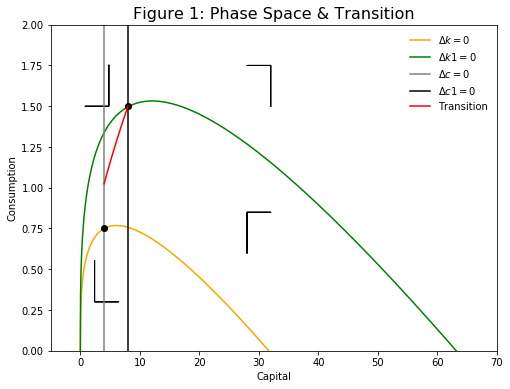

In [8]:
# Graphycal analysis
theta=0.67
delta=0.0625
z=1.63
h=0.31
beta=0.9804
k_s0=4.00
c_s0=0.75
k_ss=8.00
c_ss=1.5


def locusK(k):
    """
    A function that takes k as an input and return the value of c consistent with k_t+1=k_t    
    """
    return pow(k, 1-theta)*pow(z*h, theta) - delta*k

# Create a grid of points for plotting
gridmax, gridsize = 200, 10000
grid = np.linspace(0, gridmax, gridsize)

# Create a new figure
fig1=plt.figure(figsize=(8,6))
# Add the c and k locii
plt.plot(grid, locusK(grid), '-', color='orange', label=r'$\Delta k=0$')
z=3.25
plt.plot(grid, locusK(grid), '-', color='green', label=r'$\Delta k1=0$')
plt.axvline(k_s0, color='grey', label=r'$\Delta c=0$')
plt.plot(k_s0, c_s0, marker='.', markersize=12, color='k')
plt.axvline(k_ss, color='black', label=r'$\Delta c1=0$')
plt.plot(k_ss, c_ss, marker='.', markersize=12, color='k')
plt.plot(k_transition, c_transition, color='red', label='Transition')

# Add arrows to indicate out of steady-state dynamics
x_len = 0.02 * gridmax 
y_len = 1 / x_len   

plt.arrow(x=0.3 * k_ss, y=0.2 * c_ss, dx=0, dy=y_len)
plt.arrow(x=0.3 * k_ss, y=0.2 * c_ss, dx=x_len, dy=0)

plt.arrow(x=0.1 * k_ss + x_len, y=1 * c_ss, dx=0, dy=y_len)
plt.arrow(x=0.1 * k_ss + x_len, y=1 * c_ss, dx=-x_len, dy=0)

plt.arrow(x=3.5 * k_ss, y=0.4 * c_ss + y_len, dx=0, dy=-y_len)
plt.arrow(x=3.5 * k_ss, y=0.4 * c_ss + y_len, dx=x_len, dy=0)


plt.arrow(x=3.5 * k_ss + x_len, y=1 * c_ss + y_len, dx=0, dy=-y_len)
plt.arrow(x=3.5 * k_ss + x_len, y=1 * c_ss + y_len, dx=-x_len, dy=0)

#Set the axis, labels and title. 
plt.ylim(0, 2)
plt.xlim(-5, 70)
plt.xlabel('Capital')
plt.ylabel('Consumption')
plt.legend(frameon=False)
plt.title('Figure 1: Phase Space & Transition', fontsize=16)

The transition we got is inside the balance path. As the arrows are pointing out, if the economy fall either in the upper left area or the lower right area, the economy get trap in a divergence path. 

**d) Unexpected shocks.**

*Let the agents believe productivity $z_t$ doubles once and for all periods. However, after 10 periods, surprise the economy by cutting the productivity $z_t$ back to its original value. Compute the transition for savings, consumption, labor and output.*

Text(0.5,1,'Graph 2: Unexpected productivity shock')

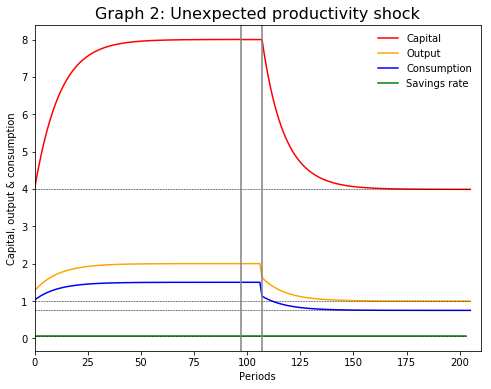

In [22]:
# The economy is in its new SS for 10 periods prior to return to its initial value. 
k_ss= 8.00
c_ss=1.50
y_ss=2.00
s_ss=0.0625
a = [(k_ss, c_ss)]
Path1 = np.repeat(a, 10, axis=0)
Pathy = np.repeat(y_ss,10)
paths = np.repeat(s_ss,10)

# shock z (Double the productivity)
params = {'theta':0.67, 'delta':0.0625, 'h':0.31, 'beta':0.9804, 'z':1.625, 'v':0}
ramsey= ramseyModel(params)


# solve for the non-linear saddle path
transition_2 = ramsey.forward_shoot(k0=k_ss, tol=1.5e-4)

#Transition values for output
transition_2=transition_2[1]
y2=[]
for i in range(0,99):
    q=0.0625*transition_2[i,0]+transition_2[i,1]
    y2.append(q)
y2=np.asarray(y2)
transition_2=np.asarray(transition_2)
k_transition=transition_2[:,0]
c_transition=transition_2[:,1]
s_transition2=[]
for i in range (0,97):
    s = (y2[i]-c_transition[i])/k_transition[i]
    s_transition2.append(s)

line = np.ones(206)*4
line2= np.ones(206)*0.75
line3=np.ones(206)*1
line4=np.ones(204)*0.0625
path=np.concatenate((transition_1, Path1,transition_2))
y_transition=np.concatenate((y1,Pathy,y2))
s_trans = np.concatenate((s_transition,paths,s_transition2))
k_transition=path[:,0]
c_transition=path[:,1]

# PLOT
fig = plt.figure(figsize=(8,6))
grid = np.arange(0, 206, 1)
grid1 = np.arange(0, 204, 1)
plt.plot(grid, k_transition, 'r', label='Capital')
plt.plot(grid, y_transition, color='orange', label='Output')
plt.plot(grid, c_transition, color='blue', label='Consumption')
plt.plot(grid1, s_trans, color='green', label='Savings rate')
plt.plot(grid, line, 'k--', linewidth=0.5)
plt.plot(grid, line3, 'k--',linewidth=0.5 )
plt.plot(grid, line2, 'k--',linewidth=0.5 )
plt.plot(grid1, line4, 'k--',linewidth=0.5 )
plt.axvline(97, color='grey')
plt.axvline(107, color='grey')
plt.xlabel('Periods')
plt.ylabel('Capital, output & consumption')
plt.xlim(0, 210)
plt.legend(frameon=False)
plt.title('Graph 2: Unexpected productivity shock', fontsize=16)


Graph 2 shows the transitions to both shocks. Grey lines are pointing out the stability phase (10 periods in the high productivity steady state). What we see is that there is the same story for capital, output and consumption: the converge to the second SS, and when the unexpected productivity shock happens, they go back the initial steady state. The story with the savings rate is different: it remains constant being equal to the depreciation rate no matter what is going one (meaning that capital and output are evolving keeping their ratio constant!). 

**e) Speed of transition with taxes**

*Can taxes explain differences in the speed of transition to steady-state?*

e1) **Permanent consumption tax**.

Adding a permanent consumption tax $t$ changes the budget constraints of the RA as follows:

$(1+t_t)c_t + k_{t+1}=f(k_t,h_t) + (1-\delta)k_t$

As a consequence, the Euler Equation is gonna look like this: 

$EE^t = \frac{c_{t+1}}{c_t}=\beta \frac{1+t_t}{1+t_{t+1}}(1+F_k - \delta)$

If the permanent consumption tax is consumption across periods (i.e., $t_t=t_{t+1}=t$), and then, the old EE is restored (i.e., $EE^t=EE$). If this is the case, nothing changes. 



e2) **Permanent capital tax**

Either if we assume a capital income tax or a capital property tax, the budget constraint will look like: 

$c_t + k_{t+1} = f(k_t,h_t) + (1 - \delta - v)k_t$

where $v$ is the capital tax. Then, the introduction of a capital tax will create an extended depreciation rate. It will impact over both, the Euler Equation and the law of motion of capital in this way:

$EE^v: \frac{c_{t+1}}{c_t}=\beta \frac{1+t_t}{1+t_{t+1}}(1+F_k - \delta -v)$

$LoM: k_{t+1}= f(k_t,h_t) - c_t + (1 - \delta - v)k_t$

In turn, it will impact the steady state levels of capital, and then, consumption and output:

$k^*= (\frac{1-\theta}{\frac{1}{\beta}+\delta + v -1})^{\frac{1}{\delta}} zh$

Then, the capital tax will beat both the steady state level and the transition. Let's compute that, starting from the initial technology level (introducing the productivity shock after that). In terms of our code, the only thing we need to do is to change the value of v from 0 to 0.15.

In [28]:
# Steady state with old parameters and capital tax. 
params = {'theta':0.67, 'delta':0.0625, 'h':0.31, 'beta':0.9804, 'z':1.63, 'v':0.05}
ramsey = ramseyModel(params)
solution=ramsey.ss(k0=4, c0=1)
k_s0=solution[0]
c_s0=solution[1]
y_s0=0.0625*k_s0+c_s0
v=k_s0/y_s0
t=0.0625*k_s0/y_s0
print ("SS capital=", "{0:.2f}".format(solution[0]))
print ("SS consumption=", "{0:.2f}".format(solution[1]))
print ("SS output=", "{0:.2f}".format(y_s0))
print ("capital/output=", "{0:.2f}".format(v))
print ("investment/output", "{0:.2f}".format(t))

SS capital= 1.97
SS consumption= 0.57
SS output= 0.69
capital/output= 2.85
investment/output 0.18


In [29]:
# Steady state with capital tax after productivity shock
params = {'theta':0.67, 'delta':0.0625, 'h':0.31, 'beta':0.9804, 'z':3.26, 'v':0.05}
ramsey = ramseyModel(params)
solution=ramsey.ss(k0=4, c0=1)
k_ss=solution[0]
c_ss=solution[1]
y_ss=0.0625*k_ss+c_ss
v=k_ss/y_ss
t1=0.0625*k_ss/y_ss
print ("SS capital=", "{0:.2f}".format(solution[0]))
print ("SS consumption=", "{0:.2f}".format(solution[1]))
print ("SS output=", "{0:.2f}".format(y_ss))
print ("capital/output=", "{0:.2f}".format(v))
print ("investment/output", "{0:.2f}".format(t1))

SS capital= 3.95
SS consumption= 1.14
SS output= 1.39
capital/output= 2.85
investment/output 0.18


In [ ]:
#Compute the transition

v=0.05
delta=0.0625
z2=3.26
theta=0.67
beta=0.9804
time=6
ka = empty(time)
ya = empty(time)
ca = empty(time)
ia = empty(time)

ka[0] = 1.97
ca[0] = 0.57


for t in range(time - 1):
    ka[t+1] = pow(ka[t], 1-theta)*pow(z2*h, theta) - ca[t] + (1-delta-v)*ka[t]
    ca[t+1] = ca[t]*beta*(1 - delta - v + (1-theta)*pow(z2*h, theta)*pow(ka[t], -theta))



With capital taxes, the speed of converge is much higher. 